### Imports necesarios

In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as random

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

## 1. Introducción
### En este cuaderno vamos a analizar el historico de acciones en bolsa de la empresa Take-Two Interactive Software, Inc. (TTWO), conocida en la industria de los videojuegos por juegos como la saga Grand Theft Auto, Borderlands, Red Dead, BioShock, Mafia: The City of Lost Heaven, WWE y más
### Origen de los datos: https://finance.yahoo.com/quote/TTWO/history/

## 2. Carga de datos y presentación de columnas

In [219]:
df = pd.read_csv("TTWO_historical_data.csv")
df.head()

,Date,Close,High,Low,Open,Volume
0,1997-04-15,3.916425,3.916425,3.416456,3.666441,1785600
1,1997-04-16,3.708104,4.166410,3.583112,3.916425,443700
2,1997-04-17,3.833096,4.083081,3.749768,3.749768,252150
3,1997-04-18,3.999753,3.999753,3.833096,3.833096,165900
4,1997-04-21,3.999753,3.999753,3.916425,3.916425,77400


### **Date:** Fecha de la cotización en formato AAAA-MM-DD.
### **Close:** Precio de cierre de la acción al final de la jornada bursátil.
### **High:** Precio más alto alcanzado por la acción durante el día.
### **Low:** Precio más bajo alcanzado por la acción durante el día.
### **Open:** Precio de apertura de la acción al inicio de la jornada bursátil.
### **Volume:** Número total de acciones negociadas en ese día.

In [220]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7031 entries, 0 to 7030
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    7031 non-null   object 
 1   Close   7031 non-null   float64
 2   High    7031 non-null   float64
 3   Low     7031 non-null   float64
 4   Open    7031 non-null   float64
 5   Volume  7031 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 329.7+ KB


None

In [221]:
display(df.describe())

,Close,High,Low,Open,Volume
count,7031.000000,7031.000000,7031.000000,7031.000000,7.031000e+03
mean,50.671251,51.402618,49.913069,50.671638,1.725066e+06
std,57.061557,57.749930,56.334312,57.064362,1.861216e+06
min,3.333127,3.416456,2.999815,3.249799,0.000000e+00
25%,11.430000,11.662973,11.150000,11.399648,9.049000e+05
50%,19.652121,20.080000,19.268811,19.678786,1.373550e+06
75%,102.105000,103.299999,99.905003,101.555000,2.024200e+06
max,217.949997,218.750000,212.460007,218.589996,5.279740e+07


In [222]:
df.isna().sum()

Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

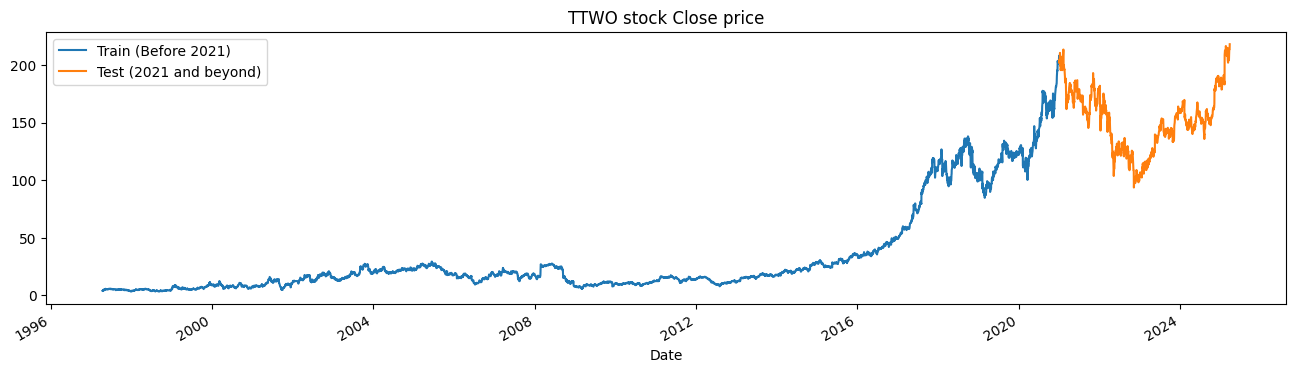

In [223]:
# Convertir 'Date' a datetime
df['Date'] = pd.to_datetime(df['Date'])

# Establecer la columna 'Date' como índice
df.set_index('Date', inplace=True)

# Función para graficar
tstart = 1997
tend = 2020

def train_test_plot(df, tstart, tend):
    df.loc[f"{tstart}":f"{tend}", "Close"].plot(figsize=(16, 4), legend=True)
    df.loc[f"{tend+1}":, "Close"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("TTWO stock Close price")
    plt.show()

# Llamar a la función
train_test_plot(df, tstart, tend)

### Dividimos el conjunto de pruebas y el de validación

In [224]:
def train_test_split(df, tstart, tend):
    train = df.loc[f"{tstart}":f"{tend}", "Close"].values
    test = df.loc[f"{tend+1}":, "Close"].values
    return train, test
training_set, test_set = train_test_split(df, tstart, tend)

### Estandarizamos los datos para eliminar valoires atípicos y anómalias

In [225]:
sc = MinMaxScaler(feature_range=(0, 1))
# Hacer el reshape es necesario porque MinMaxScaler
# espera una entrada en forma de columnas, donde cada fila representa una muestra y cada columna una característica.
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

### Construis X_train y y_train

In [226]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 120
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [227]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)
print(X_train.shape)

(5850, 120, 1)


In [228]:
X_train.shape

(5850, 120, 1)

## Modelo LSTM

### usando la API funcional

In [229]:
np.random.seed(23)
tf.random.set_seed(23)
random.seed(23)

# Definir la entrada
inputs = keras.Input(shape=(n_steps, features))

# Capa LSTM
x = layers.LSTM(units=125, activation="tanh")(inputs)

# Capa densa de salida
outputs = layers.Dense(units=1)(x)

# Crear el modelo
model_lstm = keras.Model(inputs=inputs, outputs=outputs)

# Compilar el modelo
model_lstm.compile(optimizer="Adam", loss="mae")

# Resumen del modelo
model_lstm.summary()

Model: "functional_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_34 (InputLayer)     │ (None, 120, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 125)            │        63,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,626 (248.54 KB)

 Trainable params: 63,626 (248.54 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento del modelo

In [230]:
np.random.seed(23)
tf.random.set_seed(23)
random.seed(23)
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0229
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0060
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0056
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0053
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0052
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0046
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0045
Epoch 8/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0044
Epoch 9/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0040
Epoch 10/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0039
Epoch 11/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0037
Epoch 12/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0035
Epoch 13/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0039
Epoch 14/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0035
Epoch 15/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s

In [231]:
dataset_total = df.loc[:,"Close"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [232]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("TTWO Stock Close Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("TTWO Stock Close Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

def return_mae(test, predicted):
    mae = mean_absolute_error(test, predicted)
    print("The mean absolute error is {:.2f}.".format(mae))

def return_mape(test, predicted):
    mape = mean_absolute_percentage_error(test, predicted) * 100
    print("The mean absolute percentage error is {:.2f}%".format(mape))

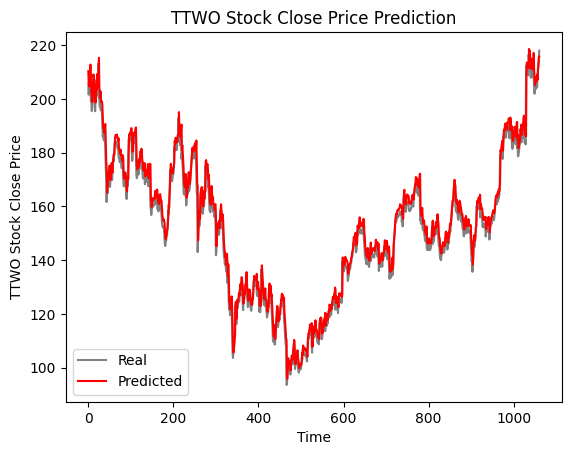

In [233]:
plot_predictions(test_set,predicted_stock_price)

In [234]:
return_mae(test_set,predicted_stock_price)
return_mape(test_set,predicted_stock_price)
return_rmse(test_set,predicted_stock_price)

The mean absolute error is 3.05.
The mean absolute percentage error is 2.05%
The root mean squared error is 3.94.


## Modelo GRU

In [235]:
np.random.seed(23)
tf.random.set_seed(23)
random.seed(23)

model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
# Compiling the RNN
model_gru.compile(optimizer="RMSprop", loss="mae")

model_gru.summary()

c:\Users\domid\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_27 (GRU)                    │ (None, 125)            │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,126 (187.99 KB)

 Trainable params: 48,126 (187.99 KB)

 Non-trainable params: 0 (0.00 B)

In [236]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0291
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0116
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0102
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0089
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0085
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0078
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0076
Epoch 8/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0072
Epoch 9/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0069
Epoch 10/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0067
Epoch 11/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0065
Epoch 12/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0061
Epoch 13/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0061
Epoch 14/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0061
Epoch 15/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


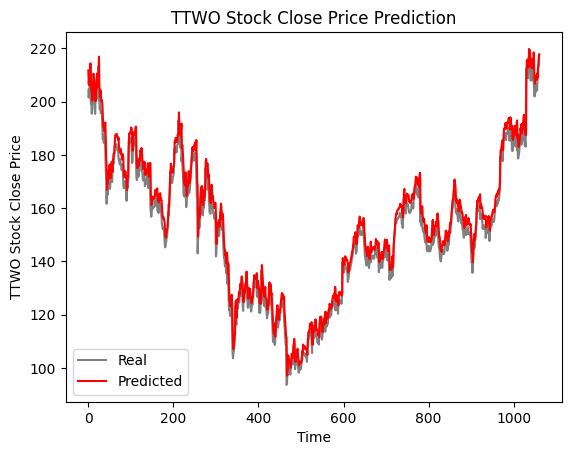

In [237]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
plot_predictions(test_set, GRU_predicted_stock_price)

In [238]:
return_mae(test_set,GRU_predicted_stock_price)
return_mape(test_set,GRU_predicted_stock_price)
return_rmse(test_set,GRU_predicted_stock_price)

The mean absolute error is 3.84.
The mean absolute percentage error is 2.57%
The root mean squared error is 4.67.


## Modelo GRU 2

In [239]:
np.random.seed(23)
tf.random.set_seed(23)
random.seed(23)

model_gru2 = Sequential()
# El parámetro return_sequences es necesario para añadir más capas
model_gru2.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features), return_sequences=True))
model_gru2.add(GRU(units=125, activation="tanh"))
model_gru2.add(Dense(units=1))

model_gru2.compile(optimizer="Adam", loss="mae")

model_gru2.summary()

model_gru2.fit(X_train, y_train, epochs=50, batch_size=32)

c:\Users\domid\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_28 (GRU)                    │ (None, 120, 125)       │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_29 (GRU)                    │ (None, 125)            │        94,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,626 (557.13 KB)

 Trainable params: 142,626 (557.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 0.0200
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0048
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0040
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0041
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0037
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 0.0039
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 0.0036
Epoch 8/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0042
Epoch 9/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 0.0037
Epoch 10/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0038
Epoch 11/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 0.0035
Epoch 12/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 0.0035
Epoch 13/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0032
Epoch 14/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 0.0036
Epoch 15/50
183/183 ━━━━━━━━━━━━

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


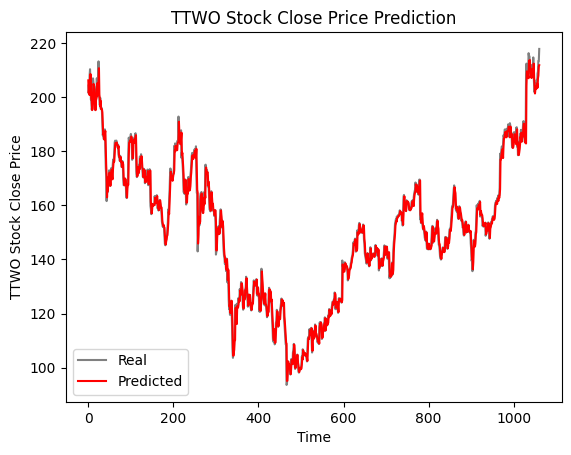

In [240]:
GRU_predicted_stock_price2 = model_gru2.predict(X_test)
GRU_predicted_stock_price2 = sc.inverse_transform(GRU_predicted_stock_price2)
plot_predictions(test_set, GRU_predicted_stock_price2)

In [241]:
return_mae(test_set,GRU_predicted_stock_price2)
return_mape(test_set,GRU_predicted_stock_price2)
return_rmse(test_set,GRU_predicted_stock_price2)

The mean absolute error is 2.14.
The mean absolute percentage error is 1.43%
The root mean squared error is 3.11.


## Modelo GRU 3

In [242]:
np.random.seed(23)
tf.random.set_seed(23)
random.seed(23)

model_gru3 = Sequential()
# El parámetro return_sequences es necesario para añadir más capas
model_gru3.add(GRU(units=64, activation="tanh", input_shape=(n_steps, features)))
model_gru3.add(Dense(units=1))

model_gru3.compile(optimizer="RMSprop", loss="mae")

model_gru3.summary()

model_gru3.fit(X_train, y_train, epochs=50, batch_size=32)

c:\Users\domid\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_30 (GRU)                    │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,929 (50.50 KB)

 Trainable params: 12,929 (50.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0339
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0105
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0092
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0084
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0077
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0074
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0069
Epoch 8/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0068
Epoch 9/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0066
Epoch 10/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0062
Epoch 11/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0062
Epoch 12/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0059
Epoch 13/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0058
Epoch 14/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0059
Epoch 15/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


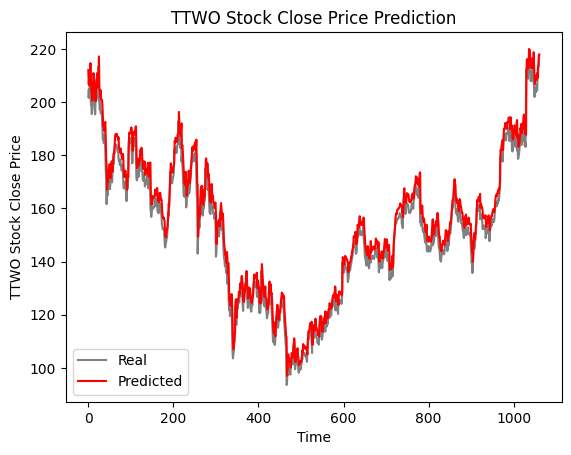

In [243]:
GRU_predicted_stock_price3 = model_gru3.predict(X_test)
GRU_predicted_stock_price3 = sc.inverse_transform(GRU_predicted_stock_price3)
plot_predictions(test_set, GRU_predicted_stock_price3)

In [244]:
return_mae(test_set,GRU_predicted_stock_price3)
return_mape(test_set,GRU_predicted_stock_price3)
return_rmse(test_set,GRU_predicted_stock_price3)

The mean absolute error is 4.02.
The mean absolute percentage error is 2.69%
The root mean squared error is 4.83.


## Comparación de modelos
### Media de las acciones diarias de cierre desde 1997 hasta la fecha actual:
### 50

| Modelo                            | Tamaño de Ventana | MAE    | MAPE    | RMSE   | Tiempo       |
|-----------------------------------|-------------------|--------|---------|--------|--------------|
| **LSTM (1 capa con 125, Adam)**   | 50                | 2.24   |  1.49%  |  3.19  | 1min, 26s    |
| **GRU (1 capa con 125, RMSprop)** | 50                | 2.64   |  1.77%  |  3.59  | 1min, 28s    |
| **GRU2 (2 capas con 125, Adam)**  | 50                | 2.17   |  1.46%  |  3.16  | 2min, 54s    |
| **GRU3 (1 capa con 64, RMSprop)** | 50                | 2.25   |  1.52%  |  3.25  | 47s          |
| **LSTM (1 capa con 125, Adam)**   | 120               | 3.05   |  2.05%  |  3.94  | 3min, 45s    |
| **GRU (1 capa con 125, RMSprop)** | 120               | 3.84   |  2.57%  |  4.67  | 3min, 45s    |
| **GRU2 (2 capas con 125, Adam)**  | **120**           |**2.14**|**1.43%**|**3.11**| **7min, 56s**|
| **GRU3 (1 capa con 64, RMSprop)** | 120               | 4.02   |  2.69%  |  4.83  | 3min, 05s    |
| **LSTM (1 capa con 125, Adam)**   | **20**            |**2.16**|**1.44%**|**3.12**| **48s**      |
| **GRU (1 capa con 125, RMSprop)** | 20                | 2.64   |  1.77%  |  3.59  | 52s          |
| **GRU2 (2 capas con 125, Adam)**  | 20                | 3.77   |  2.53%  |  4.59  | 1min, 42s    |
| **GRU3 (1 capa con 64, RMSprop)** | 20                | 2.19   |  1.47%  |  3.19  | 38s          |
| **LSTM (1 capa con 125, Adam)**   | 7                 | 2.24   |  1.49%  |  3.18  | 21s          |
| **GRU (1 capa con 125, RMSprop)** | 7                 | 2.24   |  1.49%  |  3.18  | 22s          |
| **GRU2 (2 capas con 125, Adam)**  | 7                 | 2.35   |  1.56%  |  3.29  | 38s          |
| **GRU3 (1 capa con 64, RMSprop)** | 7                 | 2.22   |  1.48%  |  3.17  | 17s          |

### El primer mejor mae y mape obtenidos es con el algoritmo GRU, utilizando 2 capas, con 125 neuronas cada una, no tiene sentido porque son como 6 meses y fijándonos en la gráfica de cuando separamos X e Y, no hay mucho patrón que se repita en 6 meses a no ser que mientras más steps, mejores resultados se pueda obtener porque coja los resultados de cuando las acciones no subían tanto en años antigüos y estaban mas regularizados en el tiempo, aunque luego enfrentándolos con el trozo de validación(y), debería de dar peores RMSE, pero en este caso, lo da mejor, también hay que fijarnos en el tiempo de ejecución en este caso son 8 minutos, en cambio en el que veo yo mejor, el segundo del que voy a hablar, ha tardado solo 48s
### Este segundo, tiene solo 2 centécimas menos de mae y 1 de mape, son obtenidos es con el algoritmo LSTM, utilizando una capa con 125 neuronas y el optimizador Adam, con 20 steps, es curioso que con más steps se obtengan peores resultados, pero tiene sentido, porque una ventana de 20 pasos es mas o menos un mes, periodo en el que las cotizaciones en bolsa, en este caso el cierre, se mantiene constante.
### Hay que destacar que más abajo de este cuaderno he intentado mejorar el modelo segundo hablado (LSTM), se han apuntando los valores obtenidos para cada ejecución, pero no tuvo mejores resultados que estos dos.

## Intento de mejora del mejor modelo 20 steps:
### LSTM con:
* 2 capa con 256 y 128 neuronas 
* RMSprop

In [245]:
np.random.seed(23)
tf.random.set_seed(23)
random.seed(23)

# Definir la entrada
inputs = keras.Input(shape=(n_steps, features))

# Primera capa LSTM
x = layers.LSTM(units=256, activation="tanh", return_sequences=True)(inputs)

# Segunda capa LSTM
x = layers.LSTM(units=128, activation="tanh", return_sequences=True)(x)

# Tercera capa LSTM
x = layers.LSTM(units=64, activation="tanh")(x)

# Capa densa de salida
outputs = layers.Dense(units=1)(x)

# Crear el modelo
model_lstm_h = keras.Model(inputs=inputs, outputs=outputs)

# Compilar el modelo
model_lstm_h.compile(optimizer="RMSprop", loss="mae")

# Resumen del modelo
model_lstm_h.summary()

# Entrenar el modelo
model_lstm_h.fit(X_train, y_train, epochs=100, batch_size=64)

Model: "functional_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_38 (InputLayer)     │ (None, 120, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 120, 256)       │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 120, 128)       │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 510,785 (1.95 MB)

 Trainable params: 510,785 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 197ms/step - loss: 0.0561
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 204ms/step - loss: 0.0234
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 206ms/step - loss: 0.0205
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 206ms/step - loss: 0.0179
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 203ms/step - loss: 0.0160
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 216ms/step - loss: 0.0160
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 235ms/step - loss: 0.0147
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 222ms/step - loss: 0.0140
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 211ms/step - loss: 0.0133
Epoch 10/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 208ms/step - loss: 0.0129
Epoch 11/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 195ms/step - loss: 0.0124
Epoch 12/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 200ms/step - loss: 0.0117
Epoch 13/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 202ms/step - loss: 0.0113
Epoch 14/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 207ms/step - loss: 0.0113
Epoch 15/100
92/92 ━━━━━━━━━━

In [246]:
dataset_total = df.loc[:,"Close"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price_h = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price_h = sc.inverse_transform(predicted_stock_price_h)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


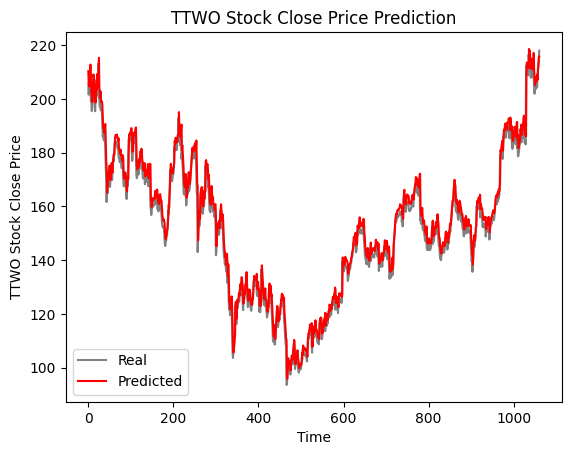

In [247]:
plot_predictions(test_set,predicted_stock_price_h)

In [ ]:
return_mae(test_set,predicted_stock_price_h)
return_mape(test_set,predicted_stock_price_h)
return_rmse(test_set,predicted_stock_price_h)
# 20 STEPS:
#The mean absolute error is 2.16.
#The mean absolute percentage error is 1.44%
#The root mean squared error is 3.12.
# 7 STEPS:
#The mean absolute error is 2.24.
#The mean absolute percentage error is 1.49%
#The root mean squared error is 3.18.
# 50 STEPS(11min):
#The mean absolute error is 2.24.
#The mean absolute percentage error is 1.49%
#The root mean squared error is 3.19.
# 120 STEPS(31 min):
#The mean absolute error is 3.05.
#The mean absolute percentage error is 2.05%
#The root mean squared error is 3.94.

The mean absolute error is 3.05.
The mean absolute percentage error is 2.05%
The root mean squared error is 3.94.
